In [1]:
import pandas as pd
import numpy as np

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import matplotlib.pyplot as plt
from xgboost import plot_importance
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb

import utils

plt.style.use('ggplot')
%matplotlib inline
from sklearn.metrics import log_loss

In [2]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')

train = utils.clean_data(train, more_clean=True)
test = utils.clean_data(test, more_clean=True)

train = utils.new_features(train)
test = utils.new_features(test)

X_train = train.drop([ 'cardio'], axis=1)
y_train = train['cardio'].values.ravel()
X_test = test.drop([], axis=1)

data = pd.concat((train.drop('cardio', axis=1), test), axis=0)
dic = data.groupby('age_group_orig')['age'].mean().to_dict()
X_train['age_dif'] = X_train[['age_group_orig', 'age']].apply(lambda x: x['age'] - dic[x['age_group_orig']], axis=1)
X_test['age_dif'] = X_test[['age_group_orig', 'age']].apply(lambda x: x['age'] - dic[x['age_group_orig']], axis=1)

dic2 = data.groupby('age_group_orig')['age'].min().to_dict()
dic3 = data.groupby('age_group_orig')['age'].max().to_dict()
X_train['age_dif2'] = X_train[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)
X_test['age_dif2']  =  X_test[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)

dic3 = data.groupby('age_group_orig')['age'].std().to_dict()
X_train['age_dif3'] = X_train[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)
X_test['age_dif3']  =  X_test[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)


In [3]:
start_columns = [
'gender',
'ap_hi',
'ap_lo',
'cholesterol',
'active_fair',
'smoke_restored',
'alco_restored',
'height_mul_log_cholesterol',
'height_mul_log_gluc',
'BMI',
'age_group',
'cholesterol_div_log_gluc',
'gluc_mul_log_age',
'age_dif2',
'ap_lo_mul_log_ap_hi',
'age_group_div_height',
'age_group_mul_log_MAP',
'cholesterol_div_ap_hi',
'ap_hi_div_age_group',
'ap_hi_mul_log_gluc',
    
# gender
# ap_hi
# ap_lo
# cholesterol
# active_fair
# smoke_restored
# alco_restored
# height_mul_log_cholesterol
# height_mul_log_gluc
# BMI
# age_group
# cholesterol_div_log_gluc
# gluc_mul_log_age
# ap_hi_mul_weight
# age_dif
# ap_lo_mul_log_ap_hi
# age_group_div_height
# age_group_mul_log_MAP
]

additional = [
    'age_dif','age_dif3',
 'ap_hi_group_3', 'ap_hi_group_4',
'ap_lo_group_3', 'ap_lo_group_4',
'age_dif', 'gluc',
    'ap_hi_group_2',
 'MAP_div_BMI',
 'cholesterol_div_weight',
 'gluc_div_age_group',
 'MAP_div_ap_lo',
 'age_group_div_cholesterol',
 'cholesterol_div_age_group',
 'ap_hi_div_cholesterol',
 'age_group_mul_log_MAP',
 'age_div_age_group',
 'ap_hi_div_weight',
 'MAP_div_gluc',
 'gluc_div_log_ap_lo',
 'cholesterol_div_ap_hi',
 'ap_lo_div_log_cholesterol',
 'ap_lo_mul_log_height',
 'age_mul_log_gluc',
 'age_group_div_height',
 'ap_hi_div_ap_lo',
 'age_group_div_log_age',
 'age_group_div_age',
 'ap_lo_mul_log_ap_hi',
 'ap_hi_div_log_age',
 'cholesterol_mul_log_ap_hi',
 'ap_hi_div_log_ap_hi',
 'ap_hi_log',
 'ap_hi_mul_ap_hi',
 'ap_hi_mul_log_ap_hi',
 'age_group_mul_log_ap_lo',
 'BMI_div_MAP',
 'height_mul_log_ap_hi',
 'cholesterol_div_log_ap_hi',
 'age_group_mul_weight',
 'weight_mul_age_group',
 'gluc_div_log_ap_hi',
 'weight_mul_log_cholesterol',
 'cholesterol_mul_log_age',
 'ap_dif_2',
 'height_div_log_gluc',
 'gluc_div_height',
 'cholesterol_div_age',
 'gluc_mul_height',
 'height_mul_gluc',
 'gluc_mul_log_height',
 'age_group_mul_gluc',
 'gluc_mul_age_group',
 'ap_hi_div_log_gluc',
 'gluc_div_log_MAP',
 'MAP_mul_age_group',
 'age_group_MAPX',
 'age_group_mul_MAP',
 'ap_hi_div_log_height',
 'weight_mul_log_age_group',
 'age_group_div_weight',
 'MAP_div_cholesterol',
 'age_group_mul_log_BMI',
 'weight_div_age_group',
 'MAP_mul_ap_lo',
 'ap_lo_mul_MAP',
 'MAP_div_weight',
 'age_mul_gluc',
 'gluc_mul_age',
 'age_group_div_log_weight',
 'ap_hi_div_gluc',
 'gluc_mul_log_cholesterol',
 'ap_lo_div_MAP',
 'height_div_BMI',
 'height_div_log_age',
 'cholesterol_div_log_age_group',
 'ap_hi_div_age_group',
 'height_div_gluc',
 'age_group_div_log_MAP',
 'cholesterol_div_log_age',
 'gluc_div_ap_hi',
 'cholesterol_mul_gluc',
 'gluc_mul_cholesterol',
 'age_div_cholesterol',
 'cholesterol_div_MAP',
 'cholesterol_mul_log_gluc',
 'age_group_mul_log_height',
 'ap_hi_mul_log_gluc',
 'BMI_div_ap_hi',
 'MAP_mul_cholesterol',
 'cholesterol_mul_MAP',
 'gluc_div_cholesterol',
 'age_group_div_log_cholesterol',
 'cholesterol_div_log_MAP',
 'age_mul_cholesterol',
 'cholesterol_mul_age',
 'age_group_mul_log_weight',
 'BMI_group',
 'height_group',
 'height_div_age_group',
 'weight_div_log_height',
 'ap_hi_mul_log_age_group',
 'weight_div_ap_lo',
 'ap_dif',
 'gluc_mul_log_age_group',
 'gluc_div_log_age_group',
 'BMI_div_cholesterol',
 'BMI_3',
 'age_group_mul_log_cholesterol',
 'BMI_div_log_age',
 'weight_group',
 'cholesterol_div_log_ap_lo',
 'BMI_mul_ap_hi',
 'ap_hi_mul_BMI',
 'MAP_div_log_age_group'
]

cols = list(start_columns)
for c in additional:
    if c not in start_columns:
        cols.append(c)

X_train = X_train[cols]
start=[]
for sc in start_columns:
    start.append(X_train.columns.get_loc(sc))
start
# X_train['age_dif']

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [4]:
# X_train[start_columns+additional]['age_dif']

In [5]:
len(X_train.columns)

130

0.00290523		age_group
0.00550992		cholesterol
0.0106191		alco_restored
0.0114206		gender
0.0136245		ap_lo
0.0137247		smoke_restored
0.0236426		cholesterol_div_log_gluc
0.028351		ap_hi_div_age_group
0.0286516		ap_hi_mul_log_gluc
0.0293528		cholesterol_div_ap_hi
0.0331597		active_fair
0.0500902		ap_lo_mul_log_ap_hi
0.0605089		ap_hi
0.0625125		height_mul_log_gluc
0.0747345		age_group_mul_log_MAP
0.0758365		age_group_div_height
0.0975756		gluc_mul_log_age
0.104688		height_mul_log_cholesterol
0.110799		age_dif2
0.162292		BMI


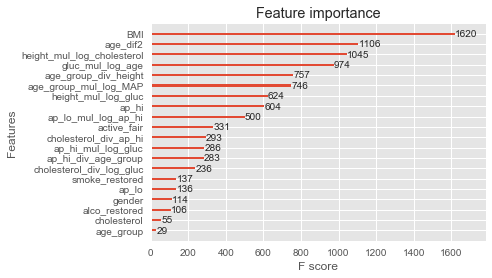

In [6]:
params = {
 'colsample_bytree': 0.875,
     'gamma': 0.05,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 5,
     'n_estimators': 369,

     'reg_alpha': 0,
     'reg_lambda': 10,
     'subsample': 0.7,
    
    'n_jobs': -1,
    'random_state': 1111,
    'silent': True,
}
clf = xgb.XGBClassifier(**params)
clf.fit(X_train[start_columns], y_train)
for a, b in sorted(zip(clf.feature_importances_, X_train[start_columns].columns)):
    print(a,b, sep='\t\t')
plot_importance(clf)
plt.show()

In [ ]:
kf = StratifiedKFold(random_state=11111, n_splits=10, shuffle=True)
sfs = SFS(clf, 
           k_features=12, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='neg_log_loss',
#            scoring='accuracy',
           n_jobs=1,
           cv=kf)

In [ ]:
sfs = sfs.fit(X_train.values, y_train, start_features=start)

In [ ]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [ ]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([-0.52, -0.55])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [ ]:
sfs.get_metric_dict()

In [88]:
for i in (0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   14,
   15,
   16,
   17,
   23,
   37,
   39):
    print(X_train.columns[i])

gender
ap_hi
ap_lo
cholesterol
active_fair
smoke_restored
alco_restored
height_mul_log_cholesterol
height_mul_log_gluc
BMI
age_group
cholesterol_div_log_gluc
gluc_mul_log_age
age_dif
ap_lo_mul_log_ap_hi
age_group_div_height
age_group_mul_log_MAP
cholesterol_div_ap_hi
ap_hi_div_age_group
ap_hi_mul_log_gluc


In [ ]:
X_train['lo_14s'].value_counts()

In [9]:
start_columns+[]

['gender',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'cholesterol',
 'height_div_ap_lo',
 'active_fair',
 'smoke_restored',
 'alco_restored',
 'height_mul_log_cholesterol',
 'height_mul_log_gluc',
 'BMI',
 'age_group',
 'cholesterol_div_log_gluc',
 'gluc_mul_log_age',
 'ap_hi_mul_weight']

In [10]:
params = {
    'colsample_bytree': 0.875,
     'gamma': 0.05,
     'learning_rate': 0.1,
     'max_depth': 5,
     'min_child_weight': 5,
     'n_estimators': 61,

     'reg_alpha': 0,
     'reg_lambda': 10,
     'subsample': 0.7,
    
    'n_jobs': 1,
    'random_state': 207,
    'silent': True,
}

def get_score(column=None):
    score1, score2 = utils.execute_model(xgb.XGBClassifier(**params),
              X_train[start_columns + ([column] if column else [])],
              y_train,
#               X_test,
#               model_name="model1",
#               n_splits=15,
              n_folds=10,
            verbose=0,
            seed=207
             )
    return score1

In [13]:
reference = get_score()
print('reference', reference)
gc.collect()
for c in X_train.columns:
    if c not in start_columns:
        score = get_score(c)
        gc.collect()
        if score < reference:
            print(score, c)   

reference 0.538316696764
0.538315499209 age
0.538287442456 gluc
0.538173636312 smoke
0.538198010197 alco
0.538307514114 active
0.538236151523 alco_fair
0.538284434267 error_group
0.538248549754 BMI_1
0.53820942483 BMI_3
0.538294944169 BMI_4
0.538207337666 ap_dif
0.538151853347 ap_dif_2
0.538310067698 age_years
0.538162316664 age_group_MAPX
0.53830746832 ap_hi_group
0.538241917485 ap_lo_group
0.538040669841 ap_hi_group_2
0.538252098393 ap_lo_group_2
0.538212055457 weight_group
0.53820596118 height_group
0.53820596118 BMI_group
0.538314903426 age_log
0.53830738488 age_mul_age
0.538314973583 age_mul_log_age
0.538315427627 age_div_log_age
0.538315499209 age_mul_age_group
0.538315942012 age_mul_log_age_group
0.538105165368 age_div_age_group
0.53824842533 age_mul_weight
0.538224409303 age_mul_log_weight
0.538260527135 age_div_weight
0.538204662914 age_mul_cholesterol
0.538196349112 age_div_cholesterol
0.538178013426 age_mul_gluc
0.538120710241 age_mul_log_gluc
0.538286503082 age_div_gluc
0.5

In [12]:
import gc
gc.collect()

9408

In [14]:
print('done!')

done!
